This is a notebook explaining the [Ink Detection progress prize on Kaggle](https://www.kaggle.com/competitions/vesuvius-challenge), which is part of the larger [Vesuvius Challenge](https://scrollprize.org).

For more background on the process of ink detection, be sure to check out [Tutorial 4: Ink Detection](https://scrollprize.org/tutorial4) on the Vesuvius Challenge website.

In this notebook we'll see how to train a simple ML model to detect ink in a papyrus fragment from a 3d x-ray scan of the fragment.

<img src="https://user-images.githubusercontent.com/177461/224853397-3cf86dc2-45b4-4e7c-9ec2-28a733791a75.jpg" width="200"/>

First, initialize some variables, and let's look at a photo of the fragment. We won't use this for training, but it's useful to see.

It's an infrared photo, since the ink is better visible in infrared light.

In [1]:
import sys
sys.sys.path.append('segment_anything')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
import time
import zarr
import glob
import PIL.Image as Image
import random
import torch.utils.data as data
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
from ipywidgets import interact, fixed
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
from torchvision import transforms
from torch.utils.data import ConcatDataset
import os
from torch.cuda import amp
import warnings
import gc
# 忽略所有警告
warnings.filterwarnings('ignore')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
seed_value = 42   # 设定随机数种子

np.random.seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)  # 为了禁止hash随机化，使得实验可复现。

torch.manual_seed(seed_value)     # 为CPU设置随机种子
torch.cuda.manual_seed(seed_value)      # 为当前GPU设置随机种子（只用一块GPU）
torch.cuda.manual_seed_all(seed_value)   # 为所有GPU设置随机种子（多块GPU）

torch.backends.cudnn.deterministic = True

# INPUT_FOLDER = "/kaggle/input/vesuvius-challenge-ink-detection"
# WORKING_FOLDER = "/kaggle/working/"
# TEMP_FOLDER = "kaggle/temp/"
INPUT_FOLDER = "data/"
WORKING_FOLDER = "working/"
TEMP_FOLDER = "temp/"
TEST_PREFIX = ['data/test/a/', 'data/test/b/']
BUFFER = 30  # Buffer size in x and y direction
Z_START = 5 # First slice in the z direction to use
Z_DIM = 48   # Number of slices in the z direction
# SIZE = 192
# EVAL_SIZE = 768
TRAIN_STEPS = 30000
ROI_SIZE = [1024, 1024, 1024]
LEARNING_RATE = 1e-3
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IS_TRAIN = True
IF_ZARR = True
CHEPOINT = 'result/ResNet3D_org/dataset-1-ResNet3D-DIM-16-[train_loss]-0.0540-[dice_score]-0.94-[iou_score]-0.89-5-epoch.pkl'
FT = False # 是否加载预训练权重
THRESHOLD = 0.55 # mask阈值

This code is a simple context manager to make it simple to get timings for our load operations.

In [2]:
class TimerError(Exception):
    pass

class Timer():
    def __init__(self, text=None):
        if text is not None:
            self.text = text + ": {:0.4f} seconds"
        else:
            self.text = "Elapsed time: {:0.4f} seconds"
        def logfunc(x):
            print(x)
        self.logger = logfunc
        self._start_time = None

    def start(self):
        if self._start_time is not None:
            raise TimerError("Timer is already running.  Use .stop() to stop it.")
        self._start_time = time.time()

    def stop(self):
        if self._start_time is None:
            raise TimerError("Timer is not running.  Use .start() to start it.")
        elapsed_time = time.time() - self._start_time
        self._start_time = None

        if self.logger is not None:
            self.logger(self.text.format(elapsed_time))

        return elapsed_time

    def __enter__(self):
        self.start()
        return self

    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.stop()

The FragmentImageData class is used to store the compressed data on disk. It takes three parameters: the sample type ("test" or "train"), the sample index in the folder, and a boolean that determines whether the data is stored in the (persistent) working directory or the temporary directory. If stored persistently, then once generated, the zarr data format can be quickly loaded in other notebooks.

If the zarr file does not already exist, it will be generated by parsing the individual image files in the corresponding input directory. Otherwise, it will quickly load from the zarr file.

The image data can be accessed as attributes of the object, largely (with the exception of fancy indexing) treated as numpy arrays:

surface_volume: the 3D X-ray tomography data
mask: the 2D boolean mask describing where data exists
truth: (Training data only) the 2D boolean mask with the ink truth set
infrared: (Training data only) the 2D infrared image of the parchment

Let's see how long it takes to generate a new zarr file from scratch on the first training set data. Note we need to clean up any pre-existing zarr data first, otherwise it will load directly from there instead of reading the input images.

In [3]:
def train_val_split(subvolume_list, label_list):
    ids = list(subvolume for subvolume in subvolume_list)
    train_csv = pd.read_csv('working/train.csv') # image_id,roi_id,x_pos,y_pos
    val_ids = [ids[3], ids[60], ids[-7]]
    train_subvolume_list = []
    val_subvolume_list = []
    train_label_list = []
    val_label_list = []
    for subvolume, label in zip(subvolume_list, label_list):
        image_id = int(subvolume.split('/')[2])
        roi_id = int(subvolume.split('/')[3])
        position = train_csv.query('image_id ==' + str(image_id) + 'and roi_id == ' + str(roi_id)).values[0][2:]
        if subvolume not in val_ids:
            position = train_csv.query('image_id ==' + str(image_id) + 'and roi_id == ' + str(roi_id)).values[0][2:]
            train_subvolume_list.append(subvolume)
            train_label_list.append([label, position])
        else:
            val_subvolume_list.append(subvolume)
            val_label_list.append([label, position])

    return train_subvolume_list, train_label_list, val_subvolume_list, val_label_list
    # # Convert the mask to a Numpy array
    # mask_array = np.array(mask)
    # # Generate random points within the mask
    # num_points = TRAINING_STEPS * BATCH_SIZE  # Number of points to generate
    # height, width = mask_array.shape
    # points = []
    # while len(points) < num_points:
    #     x = np.random.randint(0, width)
    #     y = np.random.randint(0, height)
    #     if not (x < BUFFER or x >= width-BUFFER or y < BUFFER or y >= height-BUFFER):
    #         points.append((y, x))
    # n = int(num_points * val_percent)
    # return points[:-n], points[-n:]
def get_random_pixels(mask, label_name):
    pixels = []
    # for pixel in zip(*np.where(mask == True)):
    #     if not (pixel[1] < BUFFER or pixel[1] >= ROI_SIZE[label_name]-BUFFER or pixel[0] < BUFFER or pixel[0] >= ROI_SIZE[label_name]-BUFFER):
    #         pixels.append(pixel)
    # if len(pixels) <= pixels_num:
    #     return pixels
    # random.shuffle(pixels)
    # return pixels[:pixels_num]
    # if not is_val:
    # while len(pixels) < pixels_num:
    #     x = np.random.randint(0, ROI_SIZE[label_name])
    #     y = np.random.randint(0, ROI_SIZE[label_name])
    #     if mask[y, x] and not (x < BUFFER or x >= ROI_SIZE[label_name]-BUFFER or y < BUFFER or y >= ROI_SIZE[label_name]-BUFFER):
    #         pixels.append((y, x))
    # else:
    for pixel in zip(*np.where(mask == True)):
        if not (pixel[1] < BUFFER or pixel[1] >= ROI_SIZE[label_name]-BUFFER or pixel[0] < BUFFER or pixel[0] >= ROI_SIZE[label_name]-BUFFER):
            pixels.append(pixel)
    return pixels

class SubvolumeDataset(data.Dataset):
    def __init__(self, subvolumes, labels, is_train):
        self.subvolumes = subvolumes
        self.labels = labels
        self.is_train = is_train
        transform = transforms.Compose([
            # transforms.RandomHorizontalFlip(p=0.5),
            # transforms.RandomVerticalFlip(p=0.5),
            transforms.ToTensor()
        ])
        # self.normalize =  transforms.Normalize(mean=[0.5], std=[0.5])
        # img_index = np.random.randint(0, len(subvolume_list))
        self.label_name = self.subvolumes.split('/')[2]
        position = self.labels[1]
        left ,top = position[0], position[1]
        self.label = transform(Image.open(self.labels[0])).gt(0).float().squeeze()
        mask = transform(Image.open('data/train/' + self.label_name + '/mask.png').crop((left, top, left + ROI_SIZE[int(self.label_name) - 1], top + ROI_SIZE[int(self.label_name) - 1]))).gt(0).squeeze()
        self.pixels = get_random_pixels(mask, int(self.label_name) - 1)
        subvolume = [transform(Image.open(filename)) / 65535.0  for filename in sorted(glob.glob(self.subvolumes + "/*.tif")[Z_START:Z_START+Z_DIM])]
        self.subvolume = torch.stack(subvolume, dim=0).squeeze(1)
        # import cv2 
        # cv2.imwrite('mask.png', mask.cpu().numpy() * 255)
        # cv2.imwrite('label.png', self.label.cpu().numpy() * 255)
        # cv2.imwrite('img.png', self.subvolume[0].cpu().numpy() * 255)
    def __len__(self):
        return len(self.pixels)
    def __getitem__(self, index):
        y, x = self.pixels[index]
        if self.is_train:
            subvolume = self.subvolume[:, y-BUFFER:y+BUFFER+1, x-BUFFER:x+BUFFER+1].unsqueeze(0)
            inklabel = self.label[y, x].view(1)
            return subvolume, inklabel
        else:
            subvolume = self.subvolume[:, y-BUFFER:y+BUFFER+1, x-BUFFER:x+BUFFER+1].unsqueeze(0)
            return subvolume
# IOU and Dice Score
def dice_coef(y_true, y_pred, thr=0.5, dim=(0, 1), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred > thr).to(torch.float32)
    inter = (y_true * y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2 * inter + epsilon) / (den + epsilon)).mean()
    return dice


def iou_coef(y_true, y_pred, thr=0.5, dim=(0, 1), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred > thr).to(torch.float32)
    inter = (y_true * y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true * y_pred).sum(dim=dim)
    iou = ((inter + epsilon) / (union + epsilon)).mean()
    return iou

In [4]:
root_path = 'working/crop/'
root_list = os.listdir(root_path)
subvolume_list = []
label_list = []
for i in root_list:
    file_list = os.listdir(root_path + i)
    for j in range(len(file_list) // 2):
        subvolume_list.append(root_path + i + '/' + f"{j:03d}")
        label_list.append(root_path + i + '/' + f"{j:03d}.png")
train_subvolume_list, train_label_list, val_subvolume_list, val_label_list = train_val_split(subvolume_list, label_list)
print()

We can see it took on the order of a minute to load all the images for this training dataset. However, now that we have the data on disk in our working directory, we can reload the data from that zarr much faster:

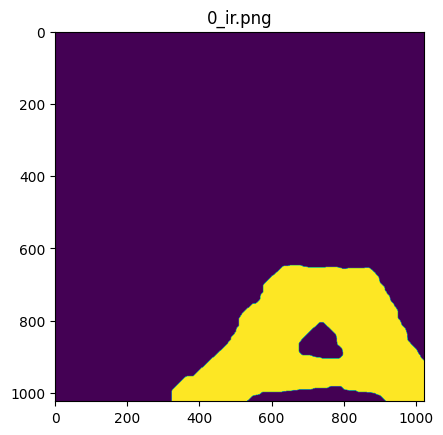

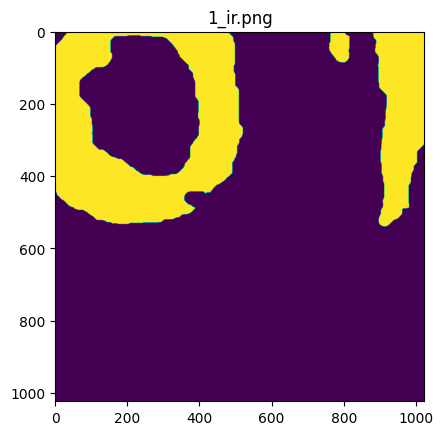

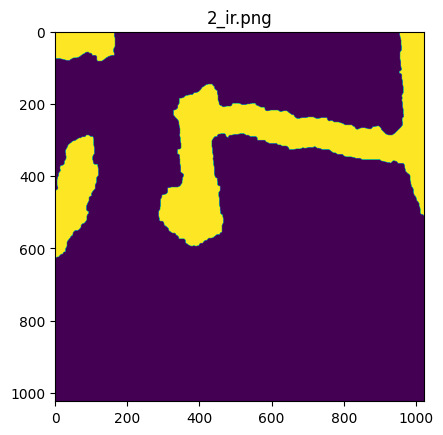

Elapsed time: 0.4056 seconds


In [5]:
with Timer():
    for i in range(len(val_label_list)):
        fig, ax = plt.subplots(1, 1)
        ax.set_title(str(i) + "_ir.png")
        ax.imshow(Image.open(val_label_list[i][0]))
    plt.show()

In [6]:
class PHNet(nn.Module):
    def __init__(self,load_weights=False):
        super(PHNet, self).__init__()
        self.seen = 0
        self.frame = Z_DIM
        self.CRPool = nn.Conv3d(1, 3, kernel_size=(2, 3, 3), stride=1, padding=(1, 1, 1), bias=False)
        self.conv11 = nn.Conv3d(in_channels=3, out_channels=3, kernel_size=(self.frame + 1,1,1), stride=1)
        self.frontend_feat = [16, 'M', 32, 'M',64]
        self.frontend_feat2 = [16, 'M', 32, 'M',64]
        self.backend_feat  = [64, 32, 16]
        self.backend_feat2  = [64, 32, 16]
        self.frontend = make_layers(self.frontend_feat, in_channels=1)
        self.frontend2 = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat, in_channels = 64, dilation = 2)
        self.backend2 = make_layers(self.backend_feat2, in_channels = 64, dilation = 2)
        self.pool = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.linear1 = nn.LazyLinear(256)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.LazyLinear(128)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.LazyLinear(1)
        # self.sigmoid = nn.Sigmoid()
        # self.output_layer = nn.Conv2d(192, 1, kernel_size=1)
        # self.relu = nn.ReLU()
        if not load_weights:
            # mod = models.resnet34(pretrained=True)
            self._initialize_weights()
            #num = 0
            # for i in range(len(self.frontend.state_dict().items())):
            #     list(self.frontend.state_dict().items())[i][1].data[:] = list(mod.state_dict().items())[i][1].data[:]
            #     list(self.frontend2.state_dict().items())[i][1].data[:] = list(mod.state_dict().items())[i][1].data[:]

    def forward(self,x):
        y = x.clone()
        y = self.CRPool(y)
        y = self.conv11(y*y)
        y = torch.squeeze(y, dim = 2)
        y = self.frontend2(y)
        y = self.backend2(y)
        x = x[:,:,-1,:,:] 
        x = self.frontend(x)
        x = self.backend(x)
        x = torch.cat([x,y], dim=1)
        # x = self.output_layer(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.linear3(x)
        # x = self.sigmoid(x)
        return x
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif (isinstance(m, nn.Conv3d)):
                if m.bias is not None:
                    nn.init.normal_(m.weight, std=0.01)
                else:
                    nn.init.constant_(m.weight, float(1/18/self.frame))


def make_layers(cfg, in_channels = 3,batch_norm=True,dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate,dilation = d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
                #layers.append(CBAM(v, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False))
            in_channels = v
    return nn.Sequential(*layers)

def main():
    model=PHNet()
    print(model)
    x = torch.rand(32, 1, Z_DIM, 61, 61)
    x = model(x)
    print(x.shape)

if __name__ == '__main__':
    main()

PHNet(
  (CRPool): Conv3d(1, 3, kernel_size=(2, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  (conv11): Conv3d(3, 3, kernel_size=(49, 1, 1), stride=(1, 1, 1))
  (frontend): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
  )
  (frontend2): Sequential(
    (0): Conv2d(3, 16, kerne

Now we'll train the model. Conceptually it looks like this:

<a href="https://user-images.githubusercontent.com/22727759/224853655-3fad9edb-c798-452e-94d0-f74efe71c08e.mp4"><img src="https://user-images.githubusercontent.com/22727759/224853385-ed190d89-f466-469c-82a9-499881759d57.gif"/></a>

This typically takes about 10 minutes.

In [7]:
model = PHNet().to(DEVICE)
model_name = 'ResNet3D'
if FT:
    try:
        checkpoint = torch.load(CHEPOINT, map_location=DEVICE)
        models_dict = model.state_dict()
        for model_part in models_dict:
            if model_part in checkpoint:
                models_dict[model_part] = checkpoint[model_part]
        model.load_state_dict(models_dict)
        print('Checkpoint loaded')
    except:
        print('Checkpoint not loaded')
        pass

In [8]:
if IS_TRAIN:
    # 实例化SummaryWriter对象
    torch.cuda.empty_cache()
    writer = SummaryWriter('result/logs')
    EPOCH = 100
    EVAL = 5
    T_max = int(300000 / BATCH_SIZE * EPOCH) + 50
    min_lr = 0.000001
    print('''
    Starting training:
        Model: {}
        Epochs: {}
        Batch size: {}
        TRAIN_STEPS: {}
        DIM: {}
        Learning rate: {}
        CUDA: {}
    '''.format(model_name,
               EPOCH,
               BATCH_SIZE,
               TRAIN_STEPS,
               Z_DIM,
               LEARNING_RATE,
               torch.cuda.is_available()))
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(),
                            lr=LEARNING_RATE
                            )
    # optimizer = optim.SGD(model.parameters(),
    #                     lr=LEARNING_RATE
    #                     )
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=min_lr)
    # scaler = amp.GradScaler()
    # accumulation_steps = SIZE * SIZE // BATCH_SIZE // 50
    # max_memory = torch.cuda.max_memory_allocated(device=DEVICE) / 1E9 if torch.cuda.is_available() else 0
    eval_datasets = []
    print('load eval:')
    for index in tqdm(range(len(val_subvolume_list))):
        eval_datasets.append(SubvolumeDataset(val_subvolume_list[index], val_label_list[index], IS_TRAIN))
    # 随即从1 2 3 中取
    random_indexs = []
    print('load train:')
    for i in range(20):
        index = np.random.randint(0, 164)
        random_indexs.append(index)
    #     random_indexs.append(i)
    # for i in range(25):
    #     index = np.random.randint(32, 134)
    #     random_indexs.append(index)
    # for i in range(15):
    #     index = np.random.randint(135, 164)
    #     random_indexs.append(index)
    train_datasets = []
    for index in tqdm(range(len(train_subvolume_list))):
        if index in random_indexs:
            train_datasets.append(SubvolumeDataset(train_subvolume_list[index], train_label_list[index], IS_TRAIN))
    gc.collect()
    print("train_index_num:", len(random_indexs))
    concat_train_dataset = ConcatDataset(train_datasets)
    for epoch in range(1, EPOCH + 1):
        train_loader = data.DataLoader(concat_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        epoch_loss = 0
        model.train()
        bar = tqdm(enumerate(train_loader), total=TRAIN_STEPS)
        # TRAINING_STEPS = len(train_loader
        for iter, (subvolumes, inklabels) in bar:
            if iter > TRAIN_STEPS:
                break
            # with amp.autocast():
            #     outputs = model(subvolumes.to(DEVICE))
            #     loss = criterion(outputs, inklabels.to(DEVICE))
            # scaler.scale(loss).backward(retain_graph=True)
            optimizer.zero_grad()
            outputs = model(subvolumes.to(DEVICE))
            loss = criterion(outputs, inklabels.to(DEVICE))
            loss.backward()
            optimizer.step()
            # scheduler.step()
            mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
            bar.set_postfix(loss=f'{loss.item():0.4f}', epoch=epoch, gpu_mem=f'{mem:0.2f} GB') #gpu_mem=f'{mem:0.2f} GB',lr=f'{optimizer.state_dict()["param_groups"][0]["lr"]:0.2e}'
            epoch_loss += loss.item()
            # 更新梯度
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # 梯度裁剪，防止梯度爆炸
            # scaler.step(optimizer)
            # scaler.update()
            # scheduler.step()
            # optimizer.zero_grad()
        writer.add_scalar('Train/Loss', epoch_loss / TRAIN_STEPS, epoch)
        if epoch % EVAL == 0:
            print('evaluation and save:')
            model.eval()
            dice_scores = []
            iou_scores = []
            for index in tqdm(range(len(eval_datasets))):
                output = torch.zeros((ROI_SIZE[int(eval_datasets[index].label_name) - 1], ROI_SIZE[int(eval_datasets[index].label_name) - 1])).float()
                true = torch.zeros((ROI_SIZE[int(eval_datasets[index].label_name) - 1], ROI_SIZE[int(eval_datasets[index].label_name) - 1])).float()
                eval_loader = data.DataLoader(eval_datasets[index], batch_size=BATCH_SIZE, shuffle=False)
                with torch.no_grad():
                    for i, (subvolumes, inklabels) in enumerate(eval_loader):
                        outputs = model(subvolumes.to(DEVICE))
                        for j, (value, true_value) in enumerate(zip(outputs, inklabels)):
                            output[eval_datasets[index].pixels[i*BATCH_SIZE+j]] = torch.sigmoid(value)
                            true[eval_datasets[index].pixels[i*BATCH_SIZE+j]] = true_value

                    # 计算准确率
                    dice_score = dice_coef(true.to(DEVICE), output.to(DEVICE), thr=THRESHOLD).item()
                    iou_socre = iou_coef(true.to(DEVICE), output.to(DEVICE), thr=THRESHOLD).item()

                    dice_scores.append(dice_score)
                    iou_scores.append(iou_socre)
                        
                    # 使用make_grid将图片转换成网格形式
                    pred_mask = make_grid(output.to(DEVICE), normalize=True)
                    true_mask = make_grid(true.to(DEVICE), normalize=True)
                    # 使用add_image方法将图片添加到TensorBoard中
                    writer.add_image('Valid/True_mask_'+ str(index), true_mask, global_step=epoch, dataformats="CHW")
                    writer.add_image('Valid/Pred_mask_'+ str(index), pred_mask, global_step=epoch, dataformats="CHW")

                # fig, (ax1, ax2) = plt.subplots(1, 2)
                # ax1.imshow(output.cpu(), cmap='gray')
                # ax2.imshow(label.cpu(), cmap='gray')
                # plt.show()
            writer.add_scalar('Val/IOU', sum(iou_scores) / len(iou_scores), epoch)
            writer.add_scalar('Val/Dice', sum(dice_scores) / len(dice_scores), epoch)
            torch.save(model.state_dict(), 'result/{}-DIM-{}-[train_loss]-{:.4f}-[dice_score]-{:.2f}-[iou_score]-{:.2f}-'.format(model_name, Z_DIM ,epoch_loss / TRAIN_STEPS, sum(dice_scores) / len(dice_scores), sum(iou_scores) / len(iou_scores)) + str(epoch) + '-epoch.pkl')
    writer.close()


    Starting training:
        Model: ResNet3D
        Epochs: 100
        Batch size: 512
        TRAIN_STEPS: 30000
        DIM: 48
        Learning rate: 0.001
        CUDA: True
    
load eval:


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


load train:


100%|██████████| 163/163 [00:08<00:00, 18.83it/s]


train_index_num: 20


  0%|          | 8/30000 [00:35<36:29:48,  4.38s/it, epoch=1, gpu_mem=7.13 GB, loss=0.4381]


KeyboardInterrupt: 

Finally, we'll generate a prediction image. We'll use the model to predict the presence of ink for each pixel in our rectangle (the val set). Conceptually it looks like this:

<a href="https://user-images.githubusercontent.com/22727759/224853653-7cffd0a4-c6fa-49a2-93c1-e3c820863a51.mp4"><img src="https://user-images.githubusercontent.com/22727759/224853379-09ae991e-02be-4ecc-a652-313165b3005c.gif"/></a>


This should take about a minute.

Remember that the model has never seen the label data within the rectangle before!

We'll plot it side-by-side with the label image. Are you able to recognize the letter "P" in it?

In [ ]:
if not IS_TRAIN:
    output_list = []
    for index in range(len(test_image_stack_list)):
        test_dataset = SubvolumeDataset(test_image_stack_list[index], None, pixels_test_rect_list[index], IS_TRAIN)
        test_eval_loader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
        output = torch.zeros_like(shape_list[index]).float()
        model.eval()
        with torch.no_grad():
            for i, (subvolumes) in enumerate(tqdm(test_eval_loader)):
                for j, value in enumerate(model(subvolumes.to(DEVICE))):
                    output[pixels_test_rect_list[index][i*BATCH_SIZE+j]] = value
            output_list.append(output)
            out = output_list[index].gt(THRESHOLD).cpu().float().numpy()
            import cv2
            cv2.imwrite(str(index + 1) + '.png', out * 255)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(output_list[0].gt(THRESHOLD).cpu(), cmap='gray')
    ax1.imshow(output_list[1].gt(THRESHOLD).cpu(), cmap='gray')
    plt.show()
    

Since our output has to be binary, we have to choose a threshold, say 40% confidence.

Finally, Kaggle expects a runlength-encoded submission.csv file, so let's output that.

In [ ]:
def rle(output):
    flat_img = np.where(output.flatten().cpu() > THRESHOLD, 1, 0).astype(np.uint8)
    starts = np.array((flat_img[:-1] == 0) & (flat_img[1:] == 1))
    ends = np.array((flat_img[:-1] == 1) & (flat_img[1:] == 0))
    starts_ix = np.where(starts)[0] + 2
    ends_ix = np.where(ends)[0] + 2
    lengths = ends_ix - starts_ix
    return " ".join(map(str, sum(zip(starts_ix, lengths), ())))
# rle_output = rle(output)
# This doesn't make too much sense, but let's just output in the required format
# so notebook works as a submission. :-)
# print("Id,Predicted\na," + rle_output + "\nb," + rle_output, file=open('submission.csv', 'w'))

Hurray! We've detected ink! Now, can you do better? :-) For example, you could start with this [example submission](https://www.kaggle.com/code/danielhavir/vesuvius-challenge-example-submission).

In [ ]:
rle_list = []
for output in outputs:
    rle_sample = rle(output)
    rle_list.append(rle_sample)
print("Id,Predicted\na," + rle_list[0] + "\nb," + rle_list[1], file=open('submission.csv', 'w'))